## Assignment 2 Machine Learning

This assignment will contain 3 questions with details as below. The due date is March 24th (Wednesday), 2021 23:59PM. Each late day will result in 20% loss of total points.

### Question 1  (40 points) You jump, I jump?

![](https://camo.githubusercontent.com/78ca11f9a2e6c36bbee928124a7d3f9abc3abb2b/68747470733a2f2f696d672d73332e6f6e6564696f2e636f6d2f69642d3537616336353563393365613835613733323935343639652f7265762d302f7261772f732d613730613530323939633033303464336535383266356230373338613366653730396533613564662e6a7067)

The RMS Titanic was a British passenger liner that sank in the North Atlantic Ocean in the early morning hours of 15 April 1912, after it collided with an iceberg during its maiden voyage from Southampton to New York City. There were an estimated 2,224 passengers and crew aboard the ship, and more than 1,500 died, making it one of the deadliest commercial peacetime maritime disasters in modern history. The RMS Titanic was the largest ship afloat at the time it entered service and was the second of three Olympic-class ocean liners operated by the White Star Line. The Titanic was built by the Harland and Wolff shipyard in Belfast. Thomas Andrews, her architect, died in the disaster.

**Titanic dataset**
The data has been split into two groups:

training set (train.csv)
test set (test.csv)
The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

Data Dictionary 

| Variable        | Definition           | Key  |
| ------------- |:-------------:| -----:|
| survival      | Survival | 0 = No, 1 = Yes |
| pclass      | Ticket class      |   1 = 1st, 2 = 2nd, 3 = 3rd |
| sex         | Gender   |      |
| age | Age in years      |     |
| sibsp | # of siblings / spouses aboard the Titanic      |   Sibling = brother, sister Spouse = husband, wife |
| parch | # of parents / children aboard the Titanic      |     |
| fare | Passenger fare      |     |
| embarked | Port of Embarkation     |   C = Cherbourg, Q = Queenstown, S = Southampton  |
| class | Class of tickets      |  First, Second, Third class   |
| ticket   | Ticket number              |             |
| adult_male |  Is male adult or not | Ture, False              |
| cabin | Cabin number  |  |


Answer the following questions using the provided dataset. You can write down intermediate results towards the final answers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.model_selection import cross_validate, ShuffleSplit, cross_val_predict, learning_curve, GridSearchCV, train_test_split
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
import random
from sklearn.tree import DecisionTreeClassifier, plot_tree
import sklearn

%matplotlib inline

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
train_data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Okay, the Age, Cabin and Embarked attributes are sometimes null (less than 891 non-null), especially the Cabin (77% are null). We will ignore the Cabin for now and focus on the rest. The Age attribute has about 19% null values, so we will need to decide what to do with them. Replacing null values with the median age seems reasonable.

The Name and Ticket attributes may have some value, but they will be a bit tricky to convert into useful numbers that a model can consume. So for now, we will ignore them.

Let's take a look at the numerical attributes:

In [5]:
train_data.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

Apparently only 38% Survived. :( That's close enough to 40%, so accuracy will be a reasonable metric to evaluate our model.

The mean Fare was 32.20 GBP, which does not seem so expensive (but it was probably a lot of money back then).

The mean Age was less than 30 years old.

Let's check that the target is indeed 0 or 1:

In [6]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

Now let's take a quick look at all the categorical attributes:

In [7]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [8]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [9]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [10]:
y_train = train_data[~train_data['Embarked'].isna()]['Survived']

The Embarked attribute tells us where the passenger embarked: C=Cherbourg, Q=Queenstown, S=Southampton.

In [11]:
train_data.dropna(subset=['Sex', 'Pclass', 'Embarked'], inplace=True)


In [12]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

In [13]:
numerical_features = imputer.fit_transform(train_data[['Age', 'SibSp', 'Parch', 'Fare']])
numerical_features

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

In [14]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [15]:
categorical_features = encoder.fit_transform(train_data[['Sex', 'Pclass', 
                                                         'Embarked']] )
categorical_features

array([[0., 1., 0., ..., 0., 0., 1.],
       [1., 0., 1., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 1., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 1., 0.]])

In [16]:
X_train = np.hstack((numerical_features, categorical_features))
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

In [17]:
y_test = test_data[~test_data['Embarked'].isna()]['Survived']

In [18]:
numerical_features_test = imputer.fit_transform(test_data[['Age', 'SibSp', 'Parch', 'Fare']])
categorical_features_test = encoder.fit_transform(test_data[['Sex', 'Pclass', 'Embarked']] )
X_test = np.hstack((numerical_features_test, categorical_features_test))
X_test

array([[34.5,  0. ,  0. , ...,  0. ,  1. ,  0. ],
       [34.5,  0. ,  0. , ...,  0. ,  1. ,  0. ],
       [47. ,  1. ,  0. , ...,  0. ,  0. ,  1. ],
       ...,
       [38.5,  0. ,  0. , ...,  0. ,  0. ,  1. ],
       [28. ,  0. ,  0. , ...,  0. ,  0. ,  1. ],
       [28. ,  1. ,  1. , ...,  1. ,  0. ,  0. ]])

**Question 1.1 (10 points)** Use logistic regression from scikit-learn library to train on the training set and predict the survival of passengers in the test set. Report the accuracy, confusion matrix, precision, recall and F1 score on both training set and test set and explain whether you have fit the data well.

In [19]:
y_train.shape

(889,)

accuracy score train: 0.81, accuracy score test:0.77
precision score train: 0.77, precision score test: 0.69
recall score train: 0.7, recall score test: 0.67
f1_score_train: 0.73, f1_score_test: 0.68


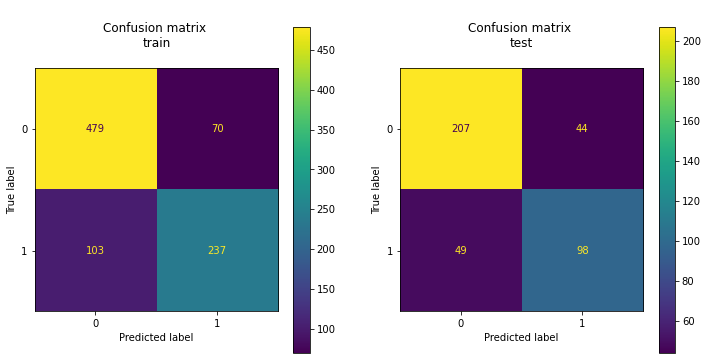

In [20]:
#Fitting the data 

log_reg = LogisticRegression(solver= 'liblinear', random_state = 0)

log_reg.fit(X_train, y_train)

y_hat_train = log_reg.predict(X_train)
y_hat_test = log_reg.predict(X_test)

acc_score_train = np.round(accuracy_score(y_train, y_hat_train),2)
acc_score_test = np.round(accuracy_score(y_test, y_hat_test), 2)

print(f'accuracy score train: {acc_score_train}, accuracy score test:{acc_score_test}')

prec_score_train = np.round(precision_score(y_train, y_hat_train), 2)
prec_score_test = np.round(precision_score(y_test, y_hat_test), 2)

print(f'precision score train: {prec_score_train}, precision score test: {prec_score_test}')

rec_score_train = np.round(recall_score(y_train, y_hat_train), 2)
rec_score_test = np.round(recall_score(y_test, y_hat_test), 2)

print(f'recall score train: {rec_score_train}, recall score test: {rec_score_test}')

f1_score_train = np.round(f1_score(y_train, y_hat_train), 2)
f1_score_test = np.round(f1_score(y_test, y_hat_test), 2)

print(f'f1_score_train: {f1_score_train}, f1_score_test: {f1_score_test}')

confusion_matrix_train = confusion_matrix(y_train, y_hat_train, labels=[0, 1])
confusion_matrix_test = confusion_matrix(y_test, y_hat_test, labels=[0, 1])

disp1 = ConfusionMatrixDisplay(confusion_matrix_train)

disp2 = ConfusionMatrixDisplay(confusion_matrix_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

disp1.plot(ax=ax1)
disp2.plot(ax=ax2)

ax1.set_title('\nConfusion matrix \ntrain\n')
ax2.set_title('\nConfusion matrix \ntest\n')

plt.show()

The accuracy scores, both on the train and test set are around 80% which is not a poor model performance. Nonetheless, we can see that the model performed badly in the other test set metrics, highlighted by the high number of both false positives and false negatives observed in the confusion matrixes. Thus, we can conclude that the model is not the best fit for the data. 

---

**Question 1.2 (10 points)** Perform 10-fold cross-validation Logistic regression on training set, and predict the survival of passgners in the test set. Report the accuracy, confusion matrix, precision, recall and F1 score on both training set and test set and explain whether you have fit the data well.

Fold 1: From the 398 passengers, 141 are predicted to have survived.
Fold 2: From the 398 passengers, 149 are predicted to have survived.
Fold 3: From the 398 passengers, 140 are predicted to have survived.
Fold 4: From the 398 passengers, 139 are predicted to have survived.
Fold 5: From the 398 passengers, 147 are predicted to have survived.
Fold 6: From the 398 passengers, 140 are predicted to have survived.
Fold 7: From the 398 passengers, 143 are predicted to have survived.
Fold 8: From the 398 passengers, 142 are predicted to have survived.
Fold 9: From the 398 passengers, 141 are predicted to have survived.
Fold 10: From the 398 passengers, 144 are predicted to have survived.


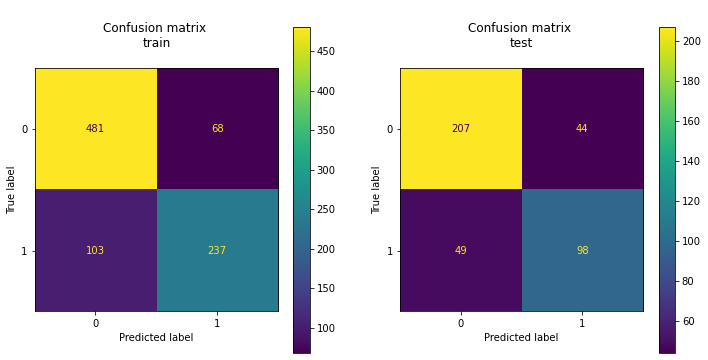

Train set  Test set
accuracy        0.81      0.79
precision       0.77      0.74
recall          0.70      0.69
f1 score        0.74      0.71

In [21]:


cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state=0) 

scores_log_reg = cross_validate(LogisticRegression(solver= 'liblinear', random_state = 0), 
                                X_train, y_train, 
                                scoring = ('accuracy', 'precision', 'recall', 'f1'),
                                cv = cv, 
                                return_train_score=True, return_estimator= True)
fold = 0
y_hat_test_list = []
y_hat_train_list = []

for model in scores_log_reg['estimator']:
    fold +=1
    print(f'Fold {fold}: From the {len(model.predict(X_test))} passengers, {np.sum(model.predict(X_test))} are predicted to have survived.')
    y_hat_train_list.append(model.predict(X_train))
    y_hat_test_list.append(model.predict(X_test))
    
df_dic = {'Train set': [np.round(np.mean(scores_log_reg['train_accuracy']),2), np.round(np.mean(scores_log_reg['train_precision']),2), np.round(np.mean(scores_log_reg['train_recall']),2), np.round(np.mean(scores_log_reg['train_f1']),2)]
          , 'Test set': [np.round(np.mean(scores_log_reg['test_accuracy']),2), np.round(np.mean(scores_log_reg['test_precision']),2), np.round(np.mean(scores_log_reg['test_recall']),2), np.round(np.mean(scores_log_reg['test_f1']),2)]}

df = pd.DataFrame(df_dic, index = ['accuracy', 'precision', 'recall', 'f1 score'])


y_hat_train = stats.mode(y_hat_train_list)[0][0]
y_hat_test = stats.mode(y_hat_test_list)[0][0]

confusion_matrix_train = confusion_matrix(y_train, y_hat_train, labels=[0, 1])
confusion_matrix_test = confusion_matrix(y_test, y_hat_test, labels=[0, 1])


disp1 = ConfusionMatrixDisplay(confusion_matrix_train)

disp2 = ConfusionMatrixDisplay(confusion_matrix_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

disp1.plot(ax=ax1)
disp2.plot(ax=ax2)

ax1.set_title('\nConfusion matrix \ntrain\n')
ax2.set_title('\nConfusion matrix \ntest\n')

plt.show()
df

Overall, we can consider the model's performance to be better as it generalizes better, since we've seen improvement on almost all the metrics except for the recall. However, the fit is still not ideal.

---

**Question 1.3 (10 points)** Plot the ROC curve for the model learned in Question 1.2. What is the TPR and FPR when the probability threshold is 0.5. Adjust the probability threshold to 0.75, and then show TPR and FPR again. What is the AUC score under two different probability thresholds?

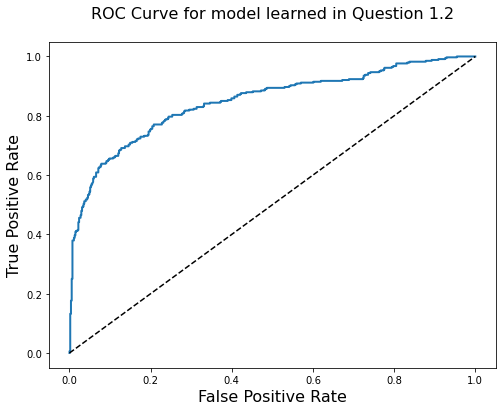

In [22]:
y_scores = cross_val_predict(log_reg, X_train, y_train, cv=10,
                             method="decision_function")

fpr, tpr, thresholds = roc_curve(y_train, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.05, 1.05, -0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.title('ROC Curve for model learned in Question 1.2\n', {'fontsize':'16'})
plt.show()

In [23]:
roc_dic = { 'FPR': fpr, "TPR": tpr, 'thresholds': thresholds}
roc_df = pd.DataFrame(roc_dic)

print(roc_df[(roc_df['thresholds']>0.74) & (roc_df['thresholds']<0.76)], roc_df[(roc_df['thresholds']>0.49) & (roc_df['thresholds']<0.51)])

         FPR       TPR  thresholds
42  0.045537  0.532353     0.74055         FPR       TPR  thresholds
67  0.07286  0.623529    0.490033


In [24]:
print(f'AUC score: {np.round(roc_auc_score(y_train, y_scores),2)}')

AUC score: 0.85


The change in thresholds do not shift the curve, yet they represent points in the curve. For that reason, the auc score is for the curve and doesn't vary with different thresholds.

---

**Question 1.4 (10 points)** Show the learning curve (the accuracy with respect to training set size) when you are training using [10, 100, 10]% of samples using cross-validation (10%, 20%..., 90%, 100%). Explain whether your model would benefit from additional data.

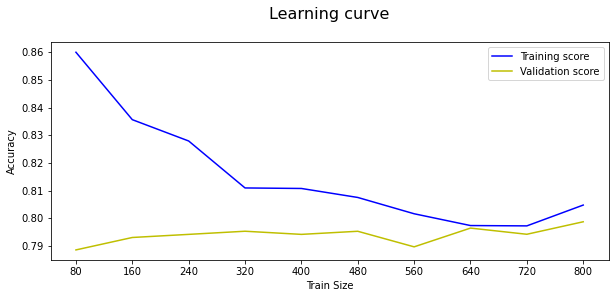

In [25]:

train_sizes, train_scores, validation_scores = learning_curve(LogisticRegression(solver= 'liblinear', random_state = 0), 
               X_train, y_train, 
               train_sizes = np.arange(0.1,1.1,0.1), 
               cv = 10, 
               scoring = 'accuracy')

plt.figure(figsize=(10,4))
plt.plot(train_sizes, train_scores.mean(axis=1), 
         'b-', 
         label = 'Training score' )
plt.plot(train_sizes, validation_scores.mean(axis=1), 'y-', label = 'Validation score')
plt.xticks(train_sizes)
plt.xlabel('Train Size')
plt.ylabel('Accuracy')
plt.title('Learning curve\n', {'fontsize':'16'})
plt.legend()
plt.show()

By looking at the curves, we can observe that, as the train size increases, accuracy on the train size steadily decreases while the validation score increases, converging around 0.8. With these trends, we can conclude that the model generalizes better with a larger train size although there are decreasing marginal returns to this effect, meaning that increasing the train size at a stage where the train set is already large does not have the same impact on the validation score as that increase in a smaller train set. For this reason, it is possible that the model improves with more training data but that increase would not be significant. 

---

## Question 2 (30 points) How many neighbors do you need?

Let's try to train and fine-tune a K Nearest Neighbor model for the cancer dataset:

In [26]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X, y = data.data, data.target

We split it into a training set and a test set using train_test_split():

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

---

**Question 2.1 (10 points)** Use grid search with cross-validation (with the help of the GridSearchCV from scikit-learn) to search hyperparameter values for a KNeighborsClassifier (e.g. number of neighbors from 2 to 50 neighbors). Plot the cross validation score with each number of neighbors. Expalin your findings.

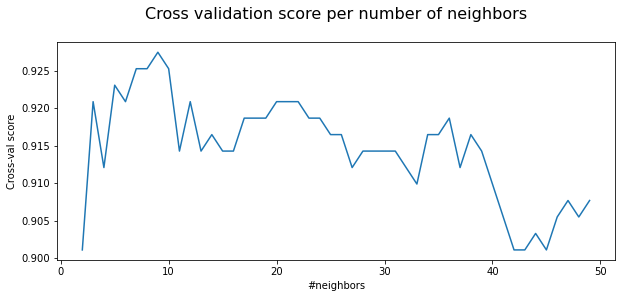

In [28]:
#using grid search with cross validation to find the best hyperparameter values for the classifier

grid_params = {'n_neighbors': [i for i in range(2,50)]}

gs = GridSearchCV(KNeighborsClassifier(), grid_params, n_jobs=-1)

gs_results = gs.fit(X_train, y_train)

scores = gs_results.cv_results_['mean_test_score']


plt.figure(figsize=(10,4))
plt.plot(range(2, 50), scores)
plt.title('Cross validation score per number of neighbors\n', {'fontsize':'16'})
plt.xlabel('#neighbors')
plt.ylabel('Cross-val score')
plt.show()

The increase in the number of neighbors has a positive impact on the cross validation score up until around 10 neighbors, decreasing slowly after that and abruptly after 40. The first trend is explained by the reduction of the effect of noise in the data, while the latter happens once with the increase with the number of neighbors, the likelihood of having neighbors with very distinct characteristics also surges, leading to more incorrect label predictions. The biggest takeaway of the graph is that, in this case, the optimal number of neighbors is 9.

---

**Question 2.2 (10 points)** Train it on the full training set using the best hyperparameters, and measure your model’s performance in tersm of accuracy, precision, recall and F1 score on the test set. You should get roughly 94% to 97% accuracy. How many number of neighbors do you have?

In [29]:
print(f"Best estimator: {gs_results.best_estimator_}")

Best estimator: KNeighborsClassifier(n_neighbors=9)


In [30]:

gs_results.best_estimator_.fit(X_train, y_train)
test_model = gs_results.best_estimator_.predict(X_test)

scores = cross_validate(gs_results.best_estimator_, 
                         X_test, y_test, 
                         cv=10, 
                         scoring = ["accuracy", "f1", "precision", 'recall'], 
                         return_train_score=True, return_estimator=True)

model = gs_results.best_estimator_


y_hat_test = model.predict(X_test)

score = model.score(X_test, y_test)

df_dic = {'Test set': [np.round(accuracy_score(y_test, y_hat_test),3), 
                       np.round(precision_score(y_test, y_hat_test),3), 
                       np.round(recall_score(y_test, y_hat_test),3), 
                       np.round(f1_score(y_test, y_hat_test),3)]}

df = pd.DataFrame(df_dic, index = ['accuracy', 'precision', 'recall', 'f1 score'])

df

Test set
accuracy      0.956
precision     0.946
recall        0.986
f1 score      0.966

---

**Question 2.3 (10 points)** Given a random patient (say patient 0, show the average characteristics of her/his nearest neighbors as well as the average distance to the patient 0, explain. 

In [31]:

distances, values_ix = model.kneighbors(X_train)

rand_point = random.randint(0, len(X_train))

print(f'Random patient: {rand_point}\n')
print(f"Average of neighbor characteristics:\n{np.mean(X_train[values_ix[rand_point]], axis=0)}\n")
print(f'Average neighbor distance:\n{np.mean(distances[rand_point])}\n')


Random patient: 141

Average of neighbor characteristics:
[1.16544444e+01 1.81622222e+01 7.57811111e+01 4.16133333e+02
 1.08064444e-01 1.18013333e-01 8.21317778e-02 4.22244444e-02
 1.97522222e-01 6.88044444e-02 3.96633333e-01 1.51815556e+00
 2.77977778e+00 2.84211111e+01 8.50577778e-03 2.63812222e-02
 3.24565556e-02 1.23300000e-02 2.86833333e-02 4.52844444e-03
 1.35355556e+01 2.53277778e+01 8.83022222e+01 5.50833333e+02
 1.46831111e-01 2.67551111e-01 2.50662222e-01 1.09996667e-01
 3.44755556e-01 9.33566667e-02]

Average neighbor distance:
41.48410211321633



In this case, since the optimal number of neighbors is 9, a random data point will have the same label as the majority of the 9 neighbors that are closer to it.

---

## Question 3 (30 points) Trees and Forest?

Let's try to try to manually create with random forest models for the moon dataset:

In [32]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

The generated random moons dataset looks like two interleaving half circles:

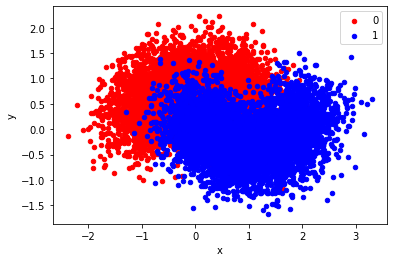

In [33]:
df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

**Question 3.1 (15 points)** generate 1,000 subsets of the training set, each containing 100 instances selected randomly (Hint: you can use Scikit-Learn’s ShuffleSplit class for this.)  Train one Decision Tree on each subset, using the best hyperparameter values (max_leaf_nodes=17 and min_samples_split=2). Evaluate these 1,000 Decision Trees on the test set. Since they were trained on smaller sets, these Decision Trees will likely perform worse than the first Decision Tree.

In [34]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

n_instances = 100

#GridSearchCV with DecisionTreeClassifier

params = {'max_leaf_nodes': list(range(2, 18)), 'min_samples_split': (list(range(2, 10)))}

gs = GridSearchCV(DecisionTreeClassifier(), 
                  param_grid = params)

gs.fit(X_train, y_train)

print('Accuracy:',np.round(accuracy_score(y_test, gs.predict(X_test)),3))



Accuracy: 0.848


In [35]:
rs = ShuffleSplit(n_splits=1000, 
                  train_size = n_instances, 
                  test_size=len(X_train) - n_instances, 
                  random_state=42)

X_split_list = []
y_split_list = []

for train_index, test_index in rs.split(X_train,y_train):
    X_split_list.append(X_train[train_index])
    y_split_list.append(y_train[train_index])
    

In [36]:

cloned_estimator = sklearn.base.clone(gs.best_estimator_)

forest = []
for i in range(1000):
    forest.append(cloned_estimator)

subsets = []
for i in range(len(y_split_list)):
    subsets.append((X_split_list[i], y_split_list[i]))

scores=[]
for tree, (X_subset, y_subset) in zip(forest, subsets):
    tree.fit(X_subset,y_subset)
    y_pred = tree.predict(X_test)
    scores.append(accuracy_score(y_test,y_pred))


print('Accuracy:',np.round(np.mean(scores),3))

Accuracy: 0.799


#### As expected, the decision trees trained on the smaller datasets performed worse when compared to the one trained with the whole training set

---

**Question 3.2 (15 points)** For each test set instance, generate the predictions of the 1,000 Decision Trees, and keep only the most frequent prediction (you can use SciPy’s mode() function for this). This gives you majority-vote predictions over the test set. Evaluate these predictions on the test set: you should obtain a slightly higher accuracy than your first model (about 0.5 to 1% higher).

In [37]:

pred_list=[]

for tree, (X_subset, y_subset) in zip(forest, subsets):
    tree.fit(X_subset,y_subset)
    pred_list.append(tree.predict(X_test))
    
mode_pred = stats.mode(pred_list)[0][0]

print('Accuracy:',accuracy_score(y_test, mode_pred))

Accuracy: 0.858
